In [17]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import pymaster as nmt
from tqdm import tqdm
import obs_cov

In [72]:
nside = 64
lmax = 3*nside-1
npix = 12*nside**2
l = np.arange(lmax+1)
c2d = l*(l+1)/2/np.pi

hits = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_hits.fits')
non_zero = np.where(hits!=0)[0]

mask = np.zeros_like(hits)
mask[non_zero] = 1
mask_apo = nmt.mask_apodization(mask, 10, 'C2')
R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])

R = ZZ @ R_unapo
# R = R_unapo
R_QU = R[npix:, npix:]

Cl_EEonly = obs_cov.get_Cl(nside, 'E')
Cl_BBonly = obs_cov.get_Cl(nside, 'B')

In [53]:
# nmc = 1024
# C_mc = np.zeros((2*npix, 2*npix))

# for i in range(nmc):
#     np.random.seed(i)
#     m = hp.synfast(Cl_EEonly, nside, new=True)    
#     m -= np.mean(m)
#     m_QU = np.concatenate([m[1], m[2]])
#     C_mc += np.outer(m_QU, m_QU)

# C_mc /= nmc

In [33]:
# C_E = obs_cov.C_ana(nside, Cl_EEonly, mask)
# C_B = obs_cov.C_ana(nside, Cl_BBonly, mask)

# sp.sparse.save_npz(f'C_E_{nside}', C_E)
# sp.sparse.save_npz(f'C_B_{nside}', C_B)

100%|███████████████████████████████████████████| 52/52 [00:03<00:00, 17.21it/s]


In [19]:
C_E = sp.sparse.load_npz(f'C_E_{nside}.npz')
C_B = sp.sparse.load_npz(f'C_B_{nside}.npz')

In [20]:
obs_C_E = R_QU @ C_E @ R_QU.T
obs_C_B = R_QU @ C_B @ R_QU.T

In [36]:
# sp.sparse.save_npz(f'obs_C_E_{nside}', obs_C_E)
# sp.sparse.save_npz(f'obs_C_B_{nside}', obs_C_B)

In [37]:
# obs_C_E = sp.sparse.load_npz(f'obs_C_E_{nside}.npz')
# obs_C_B = sp.sparse.load_npz(f'obs_C_B_{nside}.npz')

In [21]:
# sparse
diag_E = obs_C_E.diagonal()
diag_B = obs_C_B.diagonal()

sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) / 2 /1000
factor = sp.sparse.identity(obs_C_E.shape[0])*sigma**2

In [22]:
eigs, v = sp.sparse.linalg.eigsh( obs_C_B+factor , 2048, obs_C_E+factor )

In [23]:
# #dense
# diag_E = np.diag(obs_C_E.toarray())
# diag_B = np.diag(obs_C_B.toarray())

# sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) /2 /1000
# factor = np.eye(C_E.shape[0]) * sigma **2

# eigs, v = sp.linalg.eigh(obs_C_B.toarray()+factor, obs_C_E.toarray()+factor)

1.2057383430205204


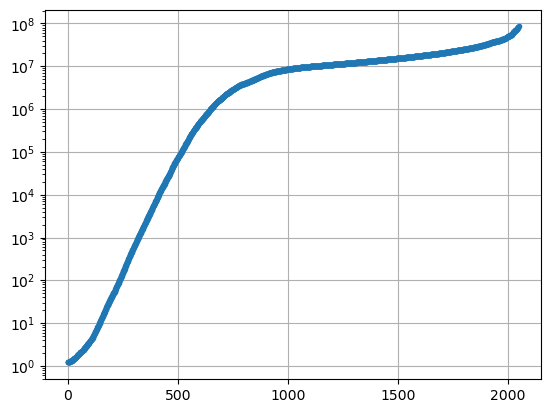

In [24]:
plt.plot(eigs, marker='.', linestyle='None')
plt.semilogy()
plt.grid()
print(eigs[0])

In [60]:
# ambi = 0
# for eig in eigsh:
#     if np.isclose(eig, 1):
#         ambi += 1
# ambi / len(eigs)

In [25]:
# purification
cut = 1.02
pass_cut = np.where(eigs >= cut)[0]

In [26]:
pure_b = v[:, pass_cut]
pure_b.shape

(98304, 2048)

In [27]:
pure_b[:,0] @ pure_b[:,-1]

-69022.33898206445

In [28]:
mask_QU = np.concatenate([mask, mask])
zeros = np.where(mask_QU==0)[0]

for i in range(pure_b.shape[1]):    
    pure_b[:,i][zeros] = 0
    pure_b[:,i] /= np.linalg.norm(pure_b[:,i], axis=0)

pure_b[:,0] @ pure_b[:,-1]

-0.0013481276857858907

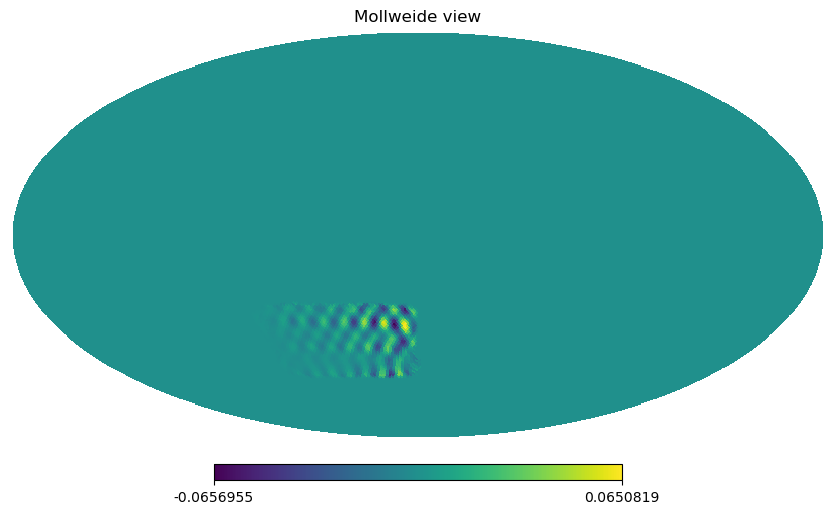

In [29]:
hp.mollview(pure_b[:,-1].reshape(2, npix)[0])

In [30]:
#Sparse
pure_b = sp.sparse.csr_array(pure_b)
pure_b

<98304x2048 sparse array of type '<class 'numpy.float64'>'
	with 9252864 stored elements in Compressed Sparse Row format>

In [31]:
pi_b = pure_b @ sp.sparse.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# pi_b = pure_b @ pure_b.T
pi_b

<98304x98304 sparse array of type '<class 'numpy.float64'>'
	with 20412324 stored elements in Compressed Sparse Row format>

In [154]:
sp.sparse.linalg.eigsh(pi_b, 3, return_eigenvectors=False)

array([2.49770458, 2.51747043, 2.53817116])

In [69]:
#dense
# pi_b = pure_b @ pure_b.T
# pi_b = pure_b @ np.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# e,_ = sp.linalg.eigh(pi_b)
# e

In [70]:
# sp.sparse.save_npz(f'pi_b_{nside}', pi_b)

In [66]:
pi_b = sp.sparse.load_npz('pi_b_64.npz')

In [114]:
m = hp.synfast(Cl_BBonly, nside, new=True)
pure_QU = (pi_b @ m[1:].flatten()).reshape(2,npix)

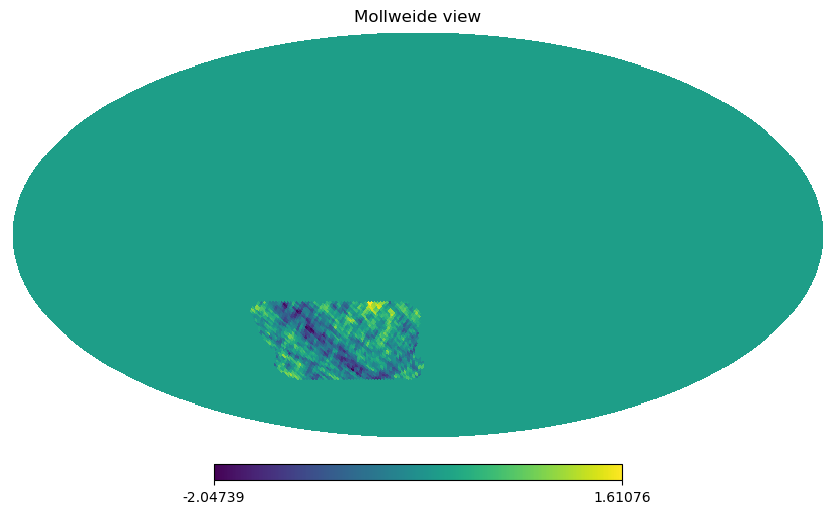

In [121]:
hp.mollview(mask*m[1])

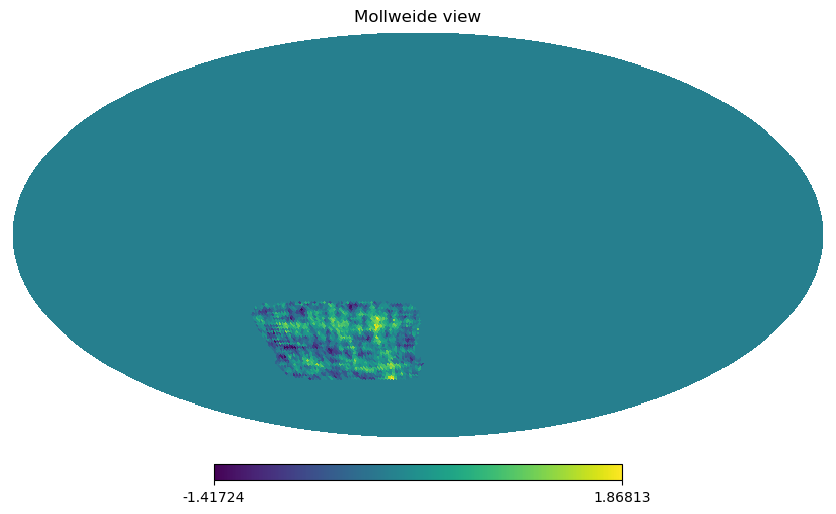

In [120]:
hp.mollview(pure_QU[1])

In [70]:
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
c2d = ell_input*(ell_input+1)/2/np.pi
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= c2d 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
c2d = c2d[:lmax+1]

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

w2 = np.sum(mask_apo**2)/np.sum(mask)
fsky = np.sum(mask)/npix

/tmp/ipykernel_36047/1965576218.py:5: RuntimeWarning: invalid value encountered in divide
  input_cls /= c2d


In [71]:
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
# fwhm = np.deg2rad(17/60)
bl = hp.gauss_beam(fwhm, lmax) 

In [99]:
#filter transfer
nmc = 128

pcl = np.zeros(lmax+1)
pcl_pure = np.zeros(lmax+1)
cl = np.zeros(lmax+1) 

for i in tqdm(range(nmc)):
    np.random.seed(i+1000)
    m = hp.synfast(input_cls_noEE, nside, new=True)
    cl += hp.anafast(m)[2]

    m_smooth = hp.smoothing(m, fwhm)
    obs_m = (R @ m_smooth.flatten()).reshape(3, npix)    
    pcl += hp.anafast(obs_m)[2]

    obs_m[1:] = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    pcl_pure += hp.anafast(obs_m)[2]
    
pcl /= nmc
pcl_pure /= nmc
cl /= nmc

100%|█████████████████████████████████████████| 128/128 [00:26<00:00,  4.77it/s]


/tmp/ipykernel_36047/3746181864.py:2: RuntimeWarning: invalid value encountered in divide
  fl = pcl / (bl**2 * input_cls[2] * fsky*w2)
/tmp/ipykernel_36047/3746181864.py:3: RuntimeWarning: invalid value encountered in divide
  fl_pure = pcl_pure / (bl**2 * input_cls[2] * fsky*w2)


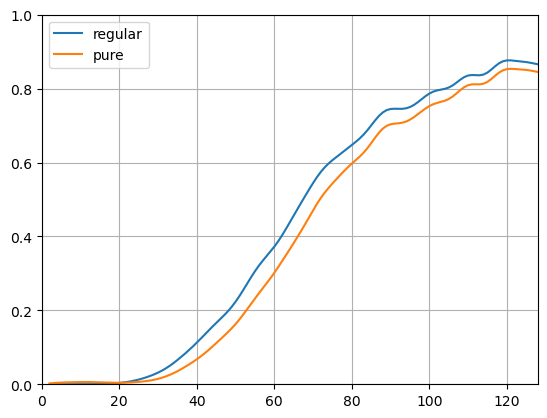

In [126]:
#reload(mylib)
fl = pcl / (bl**2 * input_cls[2] * fsky*w2)
fl_pure = pcl_pure / (bl**2 * input_cls[2] * fsky*w2)

# fl = mylib.get_fl(cl, pcl, bl, mll, fsky*w2, input_cls[2], niter=3)

# plt.plot(fl_i, label='initial')
plt.plot(fl, label='regular')
plt.plot(fl_pure, label='pure')
plt.xlim([0, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [ ]:
# import mylib
# Nl_P = mylib.get_Nl([3.3, 50, -3], lmax)#/bl**2
# # plt.plot(Nl_P)
# # plt.loglog()

# noise_cls = np.array([np.zeros_like(Nl_P), Nl_P, Nl_P, np.zeros_like(Nl_P)])

# cl_noise = np.zeros((6, lmax+1))

# nmc_noise = 1024

# for i in tqdm(range(nmc_noise)):
#     np.random.seed(i+2000)
#     noise = hp.synfast(noise_cls, nside, new=True)
#     obs_noise = (R @ noise.flatten()).reshape(3, npix)
#     # obs_noise = mask_apo * noise
#     cl_noise += hp.anafast(obs_noise)

# cl_noise /= nmc_noise
# cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])

In [161]:
#Test the purification

b = nmt.NmtBin.from_nside_linear(nside, 16)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi

nmc = 128

cl = np.zeros((nmc, len(ells)))
cl_pure = np.zeros((nmc, len(ells)))

for i in tqdm(range(nmc)):
    np.random.seed(i)
    # m = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    m = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    # m = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)

    obs_QU_unapo = R_QU_unapo @ m[1:].flatten()
    
    obs_QU = R_QU @ m[1:].flatten()
    pure_QU =  pi_b @ obs_QU
    
    f = nmt.NmtField(mask_apo, mask*obs_QU_unapo.reshape(2,npix), beam=bl*np.sqrt(fl), purify_b=True)
    cl[i] = nmt.compute_full_master(f, f, b)[3]

    f = nmt.NmtField(mask_apo, mask*pure_QU.reshape(2, npix), beam=bl*np.sqrt(fl_pure), masked_on_input=True)
    cl_pure[i] = nmt.compute_full_master(f, f, b)[3] 

mean = np.mean(cl, axis=0)
std = np.std(cl, axis=0)

mean_pure = np.mean(cl_pure, axis=0)
std_pure = np.std(cl_pure, axis=0)

100%|█████████████████████████████████████████| 128/128 [00:34<00:00,  3.74it/s]


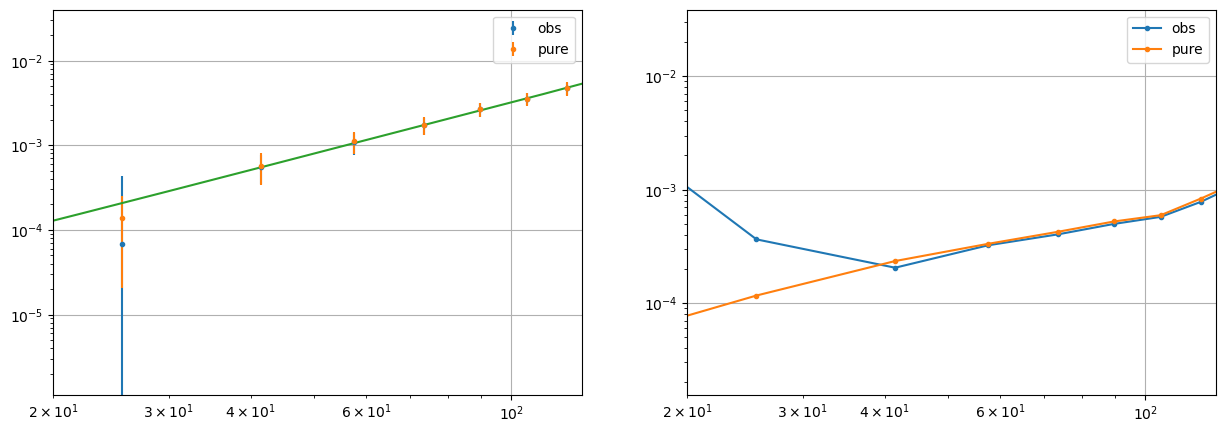

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, c2db*mean, c2db*std, fmt='.', label='obs')
axes[0].errorbar(ells, c2db*mean_pure, c2db*std_pure, fmt='.', label='pure')
axes[0].plot(c2d*input_cls[2])

# axes[0].plot(c2d*cl_noise_pol[3])

axes[1].plot(ells, c2db*std, marker='.', label='obs')
axes[1].plot(ells, c2db*std_pure, marker='.', label='pure')

for ax in axes.flatten():
    ax.set_xlim([20, 2*nside])
    ax.loglog()
    # ax.semilogy()
    ax.legend()
    ax.grid()